In [77]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt


import os, sys, argparse

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import Perceptron



# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [78]:

def get_loss_function(perceptron, ts, H_obj, dev):

    @jax.jit
    @qml.qnode(dev, interface="jax")
    def loss(param_vector):

        # hamitlonian_params = dictionary_to_hamiltonian_parameters(params_dict)

        param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

        qml.evolve(perceptron.H)(param_list, ts)

        return qml.expval(H_obj)

    return loss


In [82]:

# setting up the problem
perceptron_qubits = 8
pulse_basis = 3
ts = jnp.array([0.0, 1.0])

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron = Perceptron(perceptron_qubits, pulse_basis, basis='gaussian', pulse_width=0.01)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
print(f'Exact ground state energy: {e_ground_state_exact}')
    



Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (0.1) [X4]
+ (0.1) [X5]
+ (0.1) [X6]
+ (0.1) [X7]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]
+ (1.0) [Z3 Z4]
+ (1.0) [Z4 Z5]
+ (1.0) [Z5 Z6]
+ (1.0) [Z6 Z7]
Exact ground state energy: -7.025018814832985


/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [83]:
# getting the loss_function
loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(0)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [0.20814985 0.63308414 0.49010445 0.37887158 0.02574676 0.86008049
 0.00505647 0.31285854 0.60685395 0.250684   0.57266125 0.45742936
 0.60810339 0.06069177 0.12431146 0.91811081 0.74899102 0.38397546
 0.33957425 0.83301294 0.27867901 0.14188683 0.10110739 0.4172279
 0.90230023 0.8058159  0.26844848 0.23857475 0.01645549 0.75274451
 0.01595747 0.43117485 0.39029383 0.76452946 0.06911941 0.25560136
 0.32555255 0.4803075  0.74215996 0.20371789 0.47476035 0.5582569
 0.8775186  0.60791053 0.99342636 0.99838491 0.25698294 0.53715872
 0.90535901 0.07029284 0.23561513 0.84462682 0.72133068 0.29749312
 0.60651944]
Initial loss: 0.33472330498914243
Initial gradients: [ 0.08338907 -0.16545832 -0.24454538 -0.23760845  0.03337913  0.08601488
 -0.42985468 -1.18327417 -0.60816409 -0.29757151 -0.60439895 -0.409913
 -0.2670959   0.47293902 -0.03925729 -0.62722113  1.77025144  1.26117536
  0.4668759   0.18175151  0.13815427 -0.09566592  0.80309273  0.52354021
  1.16834469 -1.1667965

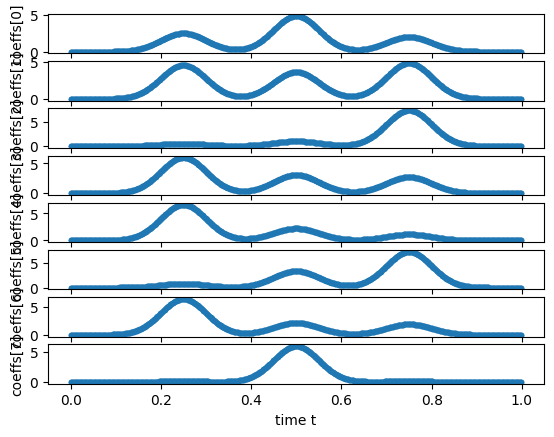

In [85]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()


In [86]:

from datetime import datetime

n_epochs = 150
param_vector = perceptron.get_random_parameter_vector(284)

# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
schedule0 = optax.constant_schedule(1)
schedule1 = optax.constant_schedule(0.1)
schedule = optax.join_schedules([schedule0, schedule1], [30])
optimizer = optax.adam(learning_rate=schedule)
# optimizer = optax.optimistic_gradient_descent(learning_rate=0.005)
opt_state = optimizer.init(param_vector)

energy = np.zeros(n_epochs + 1)
energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)
param_trajectory = []

## Compile the evaluation and gradient function and report compilation time
time0 = datetime.now()
_ = value_and_grad(param_vector)
time1 = datetime.now()
print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)
    param_vector = optax.apply_updates(param_vector, updates)

    mean_gradients[n] = np.mean(np.abs(grads))
    energy[n+1] = val

    # print(f"            param: {param_vector}")

    if not n % 10:
        print(f"{n+1} / {n_epochs}; energy discrepancy: {val-e_ground_state_exact}")
        print(f"mean grad: {mean_gradients[n]}")



print(f"Found ground state: {energy[-1]}")


grad and val compilation time: 0:00:22.805372
1 / 150; energy discrepancy: 5.886360861080523
mean grad: 0.6601297725804993
11 / 150; energy discrepancy: 8.057878255972385
mean grad: 0.31852036131172706
21 / 150; energy discrepancy: 6.413804427883579
mean grad: 0.31996437132512623
31 / 150; energy discrepancy: 1.858152329168493
mean grad: 0.5110760497728674
41 / 150; energy discrepancy: 0.7347677962603685
mean grad: 0.21545203219260378
51 / 150; energy discrepancy: 0.5473696199686051
mean grad: 0.15112255236854494
61 / 150; energy discrepancy: 0.3758422372492545
mean grad: 0.09019561243929995
71 / 150; energy discrepancy: 0.2892423297954787
mean grad: 0.05676863727662929
81 / 150; energy discrepancy: 0.2108592874563291
mean grad: 0.030059466789158842
91 / 150; energy discrepancy: 0.15127287040427628
mean grad: 0.018762428275085372
101 / 150; energy discrepancy: 0.11468791930950406
mean grad: 0.015771145628278686
111 / 150; energy discrepancy: 0.09141219412376778
mean grad: 0.00978297948

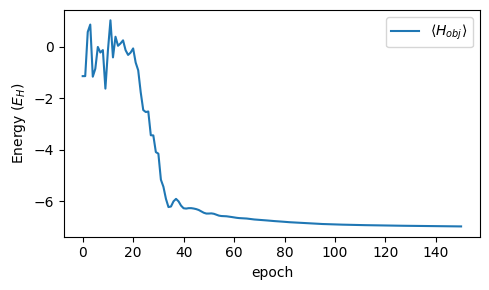

In [88]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energy 
ax.plot(y, label="$\\langle H_{{obj}}\\rangle$")
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

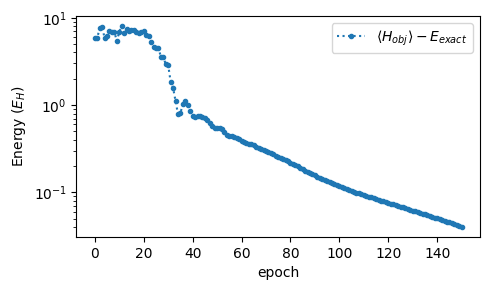

In [89]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energy - e_ground_state_exact
ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

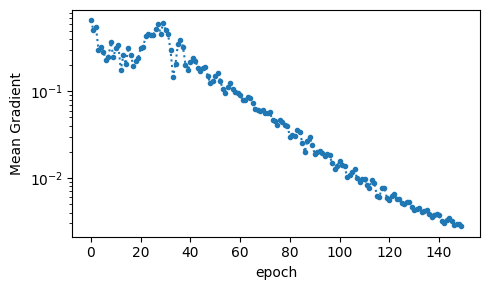

In [90]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

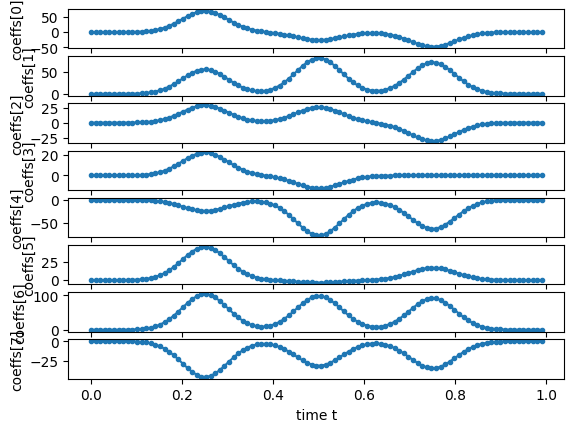

In [91]:
ts = jnp.linspace(0.0, 1, 100)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [92]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

Array([ 2.37419357e+01+0.j,  2.11906196e+01+0.j,  2.04137722e+01+0.j,
        1.95546242e+01+0.j,  1.87218681e+01+0.j,  1.40655965e+01+0.j,
        9.88042871e+00+0.j,  8.80057312e+00+0.j,  8.44353357e+00+0.j,
        6.50596634e+00+0.j,  5.13597857e+00+0.j,  3.70758766e+00+0.j,
        3.48480516e+00+0.j,  2.41325113e+00+0.j,  1.56649424e+00+0.j,
        9.67751925e-01+0.j,  4.46509338e-01+0.j,  3.23935333e-01+0.j,
        2.54295009e-01+0.j,  1.45134033e-01+0.j,  3.84423703e-02+0.j,
        3.55638917e-02+0.j,  2.83185497e-02+0.j,  2.39238209e-02+0.j,
        1.91184410e-02+0.j,  9.83935850e-03+0.j, -8.42353073e-03+0.j,
        8.15985781e-03+0.j,  6.39549262e-03+0.j, -4.72091939e-03+0.j,
       -3.48119310e-03+0.j, -3.03461517e-03+0.j,  3.20709434e-03+0.j,
        2.06786454e-03+0.j, -1.47628800e-03+0.j, -1.22691050e-03+0.j,
        1.11712976e-03+0.j, -8.38947985e-04+0.j, -7.39513126e-04+0.j,
        6.30258202e-04+0.j, -4.72250713e-04+0.j, -4.30307479e-04+0.j,
       -3.49611309e-

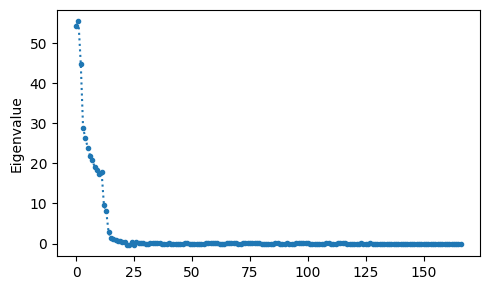

In [12]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()

plt.tight_layout()
plt.show()